In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load and sort data
df = pd.read_csv("node_ap_dataset.csv")
df = df.sort_values(by=["node_id", "timestamp"])

# Normalize node_id and features
df["node_id_norm"] = df["node_id"] / df["node_id"].max()
features = ['x_position', 'y_position', 'speed', 'direction', 'node_id_norm']
scaler = StandardScaler()
df[features[:-1]] = scaler.fit_transform(df[features[:-1]])  # Do NOT scale node_id_norm

# Parameters
TIME_STEPS = 10
FUTURE_STEP = 1

# Sequence creation
def create_sequences(df, time_steps, future_step):
    X, y = [], []
    for node_id in df['node_id'].unique():
        node_df = df[df['node_id'] == node_id]
        node_data = node_df[features + ['current_ap_id']].values
        for i in range(len(node_data) - time_steps - future_step):
            X.append(node_data[i:i+time_steps, :-1])
            y.append(node_data[i+time_steps+future_step-1, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(df, TIME_STEPS, FUTURE_STEP)

# Encode target AP
ap_classes = sorted(df['current_ap_id'].unique())
ap_to_idx = {ap: idx for idx, ap in enumerate(ap_classes)}
idx_to_ap = {v: k for k, v in ap_to_idx.items()}
y_encoded = np.array([ap_to_idx[val] for val in y])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(ap_classes), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Show some predictions
print("Sample Predictions:")
for i in range(10):
    print(f"Predicted: {idx_to_ap[y_pred[i]]}, Actual: {idx_to_ap[y_test[i]]}")


2025-05-08 14:00:40.048481: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 14:00:40.164501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 14:00:40.297723: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 14:00:40.316402: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 14:00:41.546061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Epoch 1/100
123/123 [==============================] - 5s 15ms/step - loss: 2.2417 - accuracy: 0.1697 - val_loss: 2.1901 - val_accuracy: 0.2014
Epoch 2/100
123/123 [==============================] - 1s 9ms/step - loss: 2.1748 - accuracy: 0.1971 - val_loss: 2.1808 - val_accuracy: 0.1943
Epoch 3/100
123/123 [==============================] - 1s 10ms/step - loss: 2.1341 - accuracy: 0.2293 - val_loss: 2.1511 - val_accuracy: 0.2014
Epoch 4/100
123/123 [==============================] - 1s 10ms/step - loss: 2.0941 - accuracy: 0.2393 - val_loss: 2.1185 - val_accuracy: 0.2280
Epoch 5/100
123/123 [==============================] - 1s 11ms/step - loss: 2.0405 - accuracy: 0.2633 - val_loss: 2.0693 - val_accuracy: 0.2403
Epoch 6/100
123/123 [==============================] - 1s 11ms/step - loss: 1.9676 - accuracy: 0.2891 - val_loss: 2.0152 - val_accuracy: 0.2771
Epoch 7/100
123/123 [==============================] - 1s 12ms/step - loss: 1.8768 - accuracy: 0.3211 - val_loss: 1.9275 - val_accuracy: 

In [2]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the index of max probability (predicted AP class)


31/31 [==============================] - 0s 3ms/step


In [3]:
ap_idx_to_id = {v: k for k, v in ap_to_idx.items()}  # Reverse map

print("Predicted vs Actual APs:")
for i in range(10):  # First 10 samples
    print(f"Predicted: {ap_idx_to_id[y_pred[i]]}, Actual: {ap_idx_to_id[y_test[i]]}")


Predicted vs Actual APs:
Predicted: 6, Actual: 6
Predicted: 5, Actual: 5
Predicted: 5, Actual: 5
Predicted: 6, Actual: 6
Predicted: 9, Actual: 9
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 9, Actual: 9
Predicted: 3, Actual: 3
Predicted: 2, Actual: 9


In [4]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.83


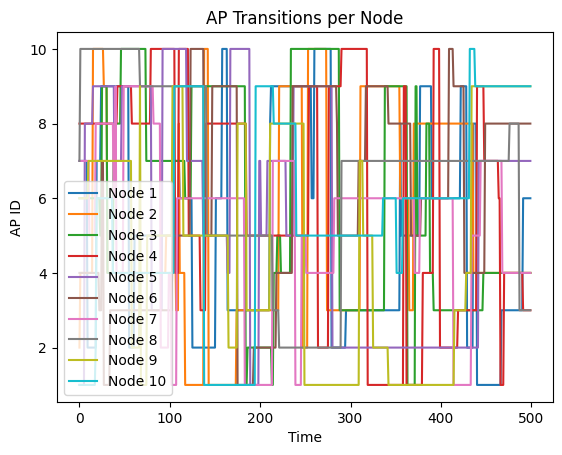

In [5]:
for node_id in df["node_id"].unique():
    node_df = df[df["node_id"] == node_id]
    plt.plot(node_df["timestamp"], node_df["current_ap_id"], label=f'Node {node_id}')
plt.xlabel("Time")
plt.ylabel("AP ID")
plt.title("AP Transitions per Node")
plt.legend()
plt.show()


In [6]:
df["next_ap"] = df.groupby("node_id")["current_ap_id"].shift(-1)
df["ap_changed"] = df["current_ap_id"] != df["next_ap"]
print("Average AP changes per node:", df.groupby("node_id")["ap_changed"].sum().mean())


Average AP changes per node: 21.3


In [7]:
def predict_future_ap(node_id, current_time, df, model):
    node_df = df[df['node_id'] == node_id]
    node_df = node_df[node_df['timestamp'] <= current_time].tail(TIME_STEPS)

    if len(node_df) < TIME_STEPS:
        print("Not enough data points.")
        return None

    # Separate features
    input_features = node_df[features].copy()
    scaled_part = scaler.transform(input_features[features[:-1]])  # scale only the 4 features
    unscaled_part = input_features[['node_id_norm']].values        # keep node_id_norm as is

    # Combine
    input_seq = np.hstack((scaled_part, unscaled_part))
    input_seq = input_seq.reshape(1, TIME_STEPS, len(features))

    prediction = model.predict(input_seq)
    predicted_ap_idx = np.argmax(prediction)
    predicted_ap = ap_classes[predicted_ap_idx]

    return predicted_ap


In [34]:
future_ap = predict_future_ap(node_id=6, current_time=1680000230, df=df, model=model)
print(f"Predicted future AP: {future_ap}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted future AP: 2


In [8]:
current_time=1680000230

In [9]:
node_id = 1
current_time = 386

# Look at a few rows *after* the current time for that node
future_df = df[(df['node_id'] == node_id) & (df['timestamp'] > current_time)]
print(future_df[['timestamp', 'current_ap_id']].head(5))


     timestamp  current_ap_id
387        387              9
388        388              9
389        389              9
390        390              6
391        391              6


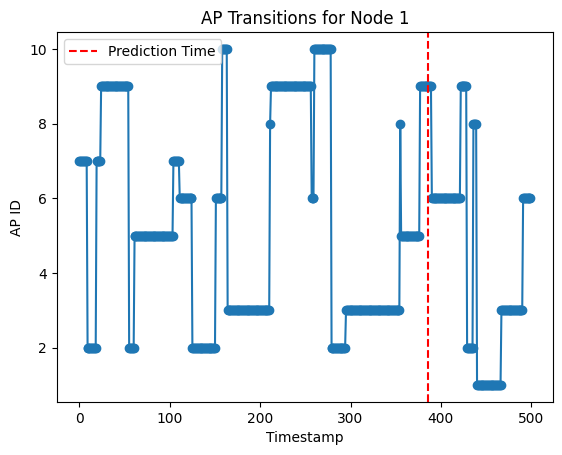

In [10]:
import matplotlib.pyplot as plt

subset = df[df['node_id'] == node_id]
plt.plot(subset['timestamp'], subset['current_ap_id'], marker='o')
plt.axvline(current_time, color='red', linestyle='--', label='Prediction Time')
plt.xlabel('Timestamp')
plt.ylabel('AP ID')
plt.title(f'AP Transitions for Node {node_id}')
plt.legend()
plt.show()


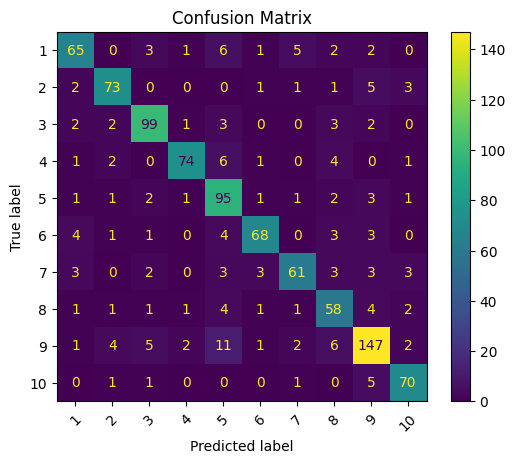

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ap_classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [12]:
model.save("ap_prediction.h5")

/home/arjunrao/mini_proj_6/lstm_venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import socket
import json
import time

def send_prediction_to_controller(predicted_ap, node_id):
    msg = {
        "type": "future_ap_prediction",
        "node_id": int(node_id),
        "predicted_ap": int(predicted_ap)
    }

    udp_ip = "127.0.0.1"
    udp_port = 9999
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(json.dumps(msg).encode(), (udp_ip, udp_port))
    print(f"Sent prediction for node {node_id}: {predicted_ap}")

# Assuming you have these already defined elsewhere
# df = ... (your dataset)
# model = ... (your trained LSTM model)
# predict_future_ap = ... (your prediction function)

while True:
    current_time = int(time.time())  # Use current system time or simulated time

    for node_id in range(1, 10):  # node IDs from 1 to 9
        future_ap = predict_future_ap(node_id=node_id, current_time=current_time, df=df, model=model)
        if future_ap is not None:
            send_prediction_to_controller(future_ap, node_id=node_id)
        else:
            print(f"No prediction available for node {node_id} at time {current_time}")
    
    time.sleep(5)  # Wait for 5 seconds before sending next round of predictions


1/1 [==============================] - 0s 38ms/step
Sent prediction for node 6: 5
1/1 [==============================] - 0s 64ms/step
Sent prediction for node 6: 5
1/1 [==============================] - 0s 41ms/step
Sent prediction for node 6: 5
1/1 [==============================] - 0s 35ms/step
Sent prediction for node 6: 5


KeyboardInterrupt: 